<a href="https://colab.research.google.com/github/Raoina/Spectra-2-Image/blob/main/notebooks/Models/PLS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Trial Results

Here is a comparison of the R-squared scores obtained in each trial:

| Trial   | Approach                                                                 | Key Result (R-squared)                                  |
|---------|--------------------------------------------------------------------------|---------------------------------------------------------|
| Trial 1 | PLS without cross-validation (split 70/30)                               | Highest average R-squared achieved: **0.3890** |
| Trial 2 | PLS with 5-fold cross-validation for optimal components (entire dataset) | Highest average R-squared achieved (with 6 components): **0.3894** |
| Trial 3 | PLS with preprocessing and 5-fold cross-validation (entire dataset)      | Highest average R-squared achieved (with 6 components): **0.4035** |
| Trial 4 | PLS with preprocessing and 5-fold cross-validation (dataset of 100, 1000 and 4000)      | Highest average R-squared achieved Respectively: **0.4906, 0.4376, 0.3843** |

**Summary:**

*   **Trial 1** provided R-squared scores on a test set after a simple train-test split.
*   **Trial 2** used cross-validation to find the optimal number of components, reporting the average R-squared across folds.
*   **Trial 3** incorporated preprocessing steps and used cross-validation to find the optimal components, showing a slight improvement in the average R-squared compared to Trial 2.
*   **Trial 4** incorporated preprocessing steps and used cross-validation, chopped the data into substes of 100, 1000 and 4000 samples.

Further analysis could involve comparing the individual R-squared scores for each target variable after preprocessing.

In [3]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install tabulate
import tabulate

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Si-Ware/LUCAS.SOIL_corr.csv')
# Images path '/content/drive/MyDrive/Si-Ware/3h_1121_spider_plots'
print(df.shape)
#df.head()

/tmp/ipython-input-2228460008.py:1: DtypeWarning: Columns (1,2,4216,4231,4234,4237,4274) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Si-Ware/LUCAS.SOIL_corr.csv')


(19036, 4288)


In [12]:
spc_columns = [col for col in df.columns if col.startswith('spc')]
spc_df = df[spc_columns]
#display(spc_df.head())

In [13]:
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']
concen_df = df[concen_columns]
#display(concen_df.tail())

## 4 Trials:
1) without cross validation
2) with cross validation
3) with cross validation and preprocessing (Normalization + Transmission2Absorbance + SNV + mean centring)
4) 100 and 1000 subset of data with cross validation and preprocessing


 ---

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
import numpy as np

# X and y are already defined from previous cells (first 1000 samples)
# batch_size is already defined from previous cells

# Handle missing values in y by dropping corresponding rows in X and y from the first 1000 samples
nan_mask = y.isnull().any(axis=1)
X_cleaned = X[~nan_mask]
y_cleaned = y[~nan_mask]

best_n_components = 0
best_r2_score = -np.inf

# Iterate through different numbers of components starting from 5 up to 100
for n_components in range(5, 101):
    # Ensure n_components does not exceed the minimum dimension of the cleaned data
    if n_components > min(X_cleaned.shape[1], y_cleaned.shape[1]):
        print(f"Reached maximum possible components ({min(X_cleaned.shape[1], y_cleaned.shape[1])}). Stopping.")
        break

    pls = PLSRegression(n_components=n_components)
    pls.fit(X_cleaned, y_cleaned)
    y_pred = pls.predict(X_cleaned) # Predict on the training data to evaluate

    # Calculate R-squared score
    current_r2_score = r2_score(y_cleaned, y_pred)

    print(f"Number of components: {n_components}, R-squared: {current_r2_score:.4f}")

    # Check if the current R-squared score is better than the best one found so far
    if current_r2_score > best_r2_score:
        best_r2_score = current_r2_score
        best_n_components = n_components

print(f"\nOptimal number of components based on highest R-squared: {best_n_components}")
print(f"Highest R-squared achieved: {best_r2_score:.4f}")

# Train the final model with the best number of components
pls = PLSRegression(n_components=best_n_components)
pls.fit(X_cleaned, y_cleaned)

print("Partial Least Squares (PLS) model created and trained with optimal components for highest R-squared.")

# You can now use the trained model to make predictions on new data
# X_new = np.random.rand(10, X.shape[1]) # New data for prediction (ensure same number of features as X)
# y_pred = pls.predict(X_new)
#
# print("Example prediction shape:", y_pred.shape)

Number of components: 5, R-squared: 0.3839
Number of components: 6, R-squared: 0.4380
Reached maximum possible components (6). Stopping.

Optimal number of components based on highest R-squared: 6
Highest R-squared achieved: 0.4380
Partial Least Squares (PLS) model created and trained with optimal components for highest R-squared.


# Trial 1
Use all the data, split it into 70% for training and 30% for testing, train a PLS regression model, and plot the results.

## Prepare data

### Subtask:
Use the full dataset and handle missing values in the target variables.


In [ ]:
spc_columns = [col for col in df.columns if col.startswith('spc')]
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']

X_full = df[spc_columns]
y_full = df[concen_columns]

nan_mask_full = y_full.isnull().any(axis=1)
X_cleaned_full = X_full[~nan_mask_full]
y_cleaned_full = y_full[~nan_mask_full]

print("Shape of X_full:", X_full.shape)
print("Shape of y_full:", y_full.shape)
print("Shape of X_cleaned_full:", X_cleaned_full.shape)
print("Shape of y_cleaned_full:", y_cleaned_full.shape)

Shape of X_full: (19036, 4200)
Shape of y_full: (19036, 6)
Shape of X_cleaned_full: (17939, 4200)
Shape of y_cleaned_full: (17939, 6)


## Split data

### Subtask:
Split the cleaned data into 70% for training and 30% for testing.


**Reasoning**:
Import the train_test_split function and split the cleaned data into training and testing sets with a 70/30 split and a fixed random state for reproducibility.



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cleaned_full, y_cleaned_full, test_size=0.3, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (12557, 4200)
Shape of X_test: (5382, 4200)
Shape of y_train: (12557, 6)
Shape of y_test: (5382, 6)


## Train model

### Subtask:
Train the PLS regression model on the training data.


In [ ]:
pls_model = PLSRegression(n_components=best_n_components)
pls_model.fit(X_train, y_train)

print("Partial Least Squares (PLS) model trained on the training data.")

Partial Least Squares (PLS) model trained on the training data.


**Reasoning**:
Use the trained PLS model to predict on the test data and print the shape of the predictions.



## Evaluate and plot

### Subtask:
Evaluate the model's performance and plot the actual vs. predicted values for each target variable.


**Reasoning**:
Calculate and print the R-squared score for each target variable and then iterate through each target variable to create scatter plots of actual vs. predicted values, including a diagonal line for reference.



R-squared for OC: 0.4669
R-squared for N: 0.3643
R-squared for CEC: 0.3395
R-squared for pH.in.H2O: 0.5044
R-squared for sand: 0.2376
R-squared for clay: 0.3606


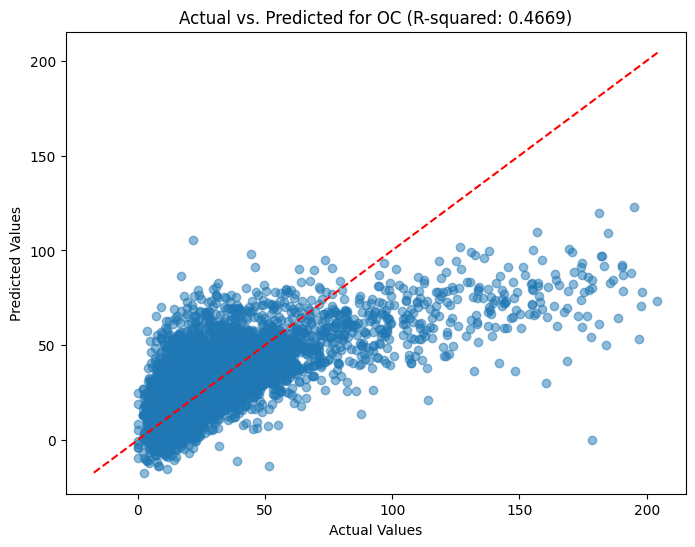

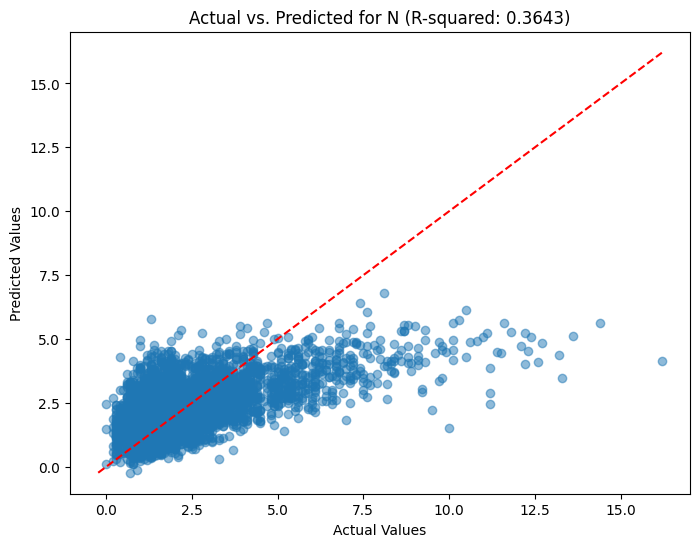

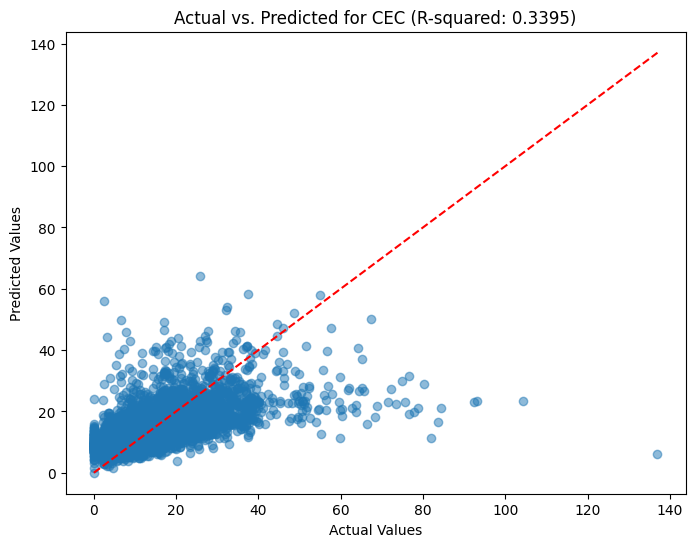

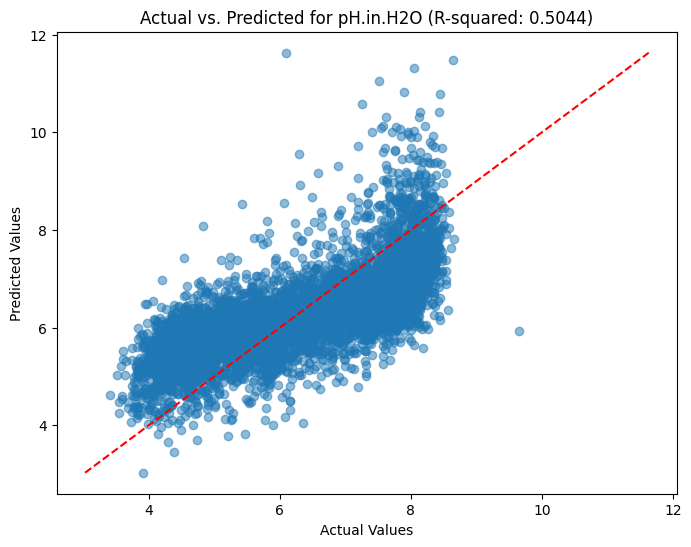

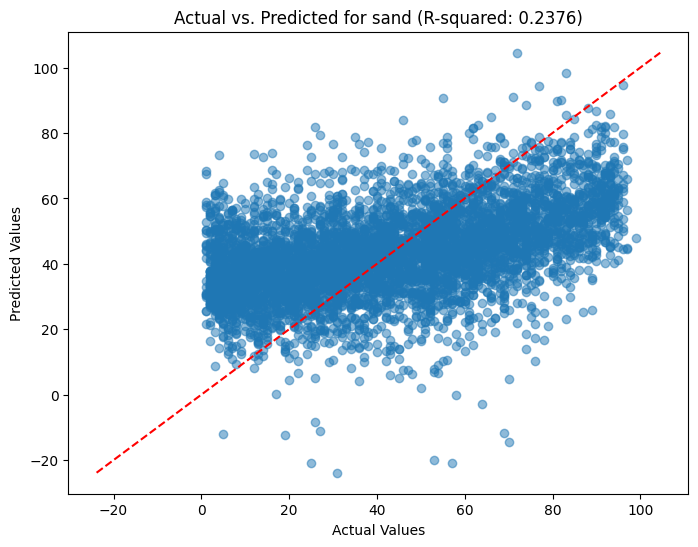

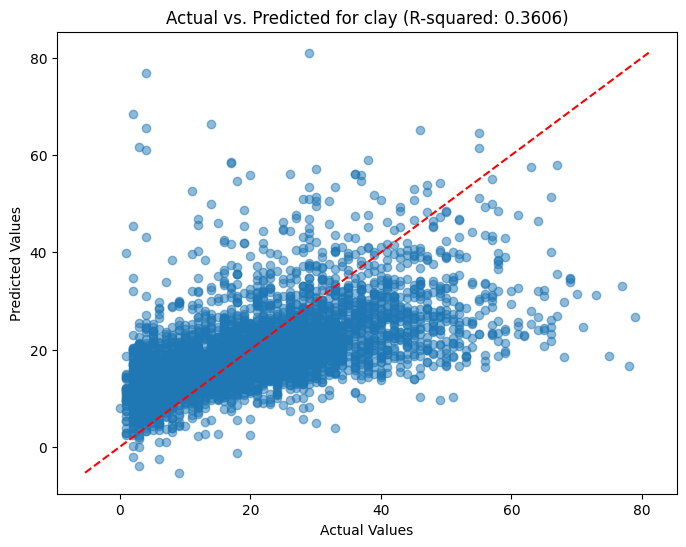

In [ ]:
# Calculate R-squared for each target variable
r2_scores = {}
for i, col in enumerate(concen_columns):
    r2 = r2_score(y_test[col], y_pred[:, i])
    r2_scores[col] = r2
    print(f"R-squared for {col}: {r2:.4f}")

# Plot actual vs. predicted values for each target variable
for i, col in enumerate(concen_columns):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[col], y_pred[:, i], alpha=0.5)
    plt.title(f'Actual vs. Predicted for {col} (R-squared: {r2_scores[col]:.4f})')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    # Add a diagonal line
    max_val = max(y_test[col].max(), y_pred[:, i].max())
    min_val = min(y_test[col].min(), y_pred[:, i].min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    plt.show()

# Trial 1 Summary:

### Data Analysis Key Findings

*   The initial dataset contained 19036 rows. After handling missing values in the target variables, 17939 rows remained for analysis.
*   The cleaned data was split into training (12557 samples) and testing (5382 samples) sets, representing approximately 70% and 30% respectively.
*   A PLS regression model was trained on the training data using a previously determined optimal number of components.
*   The trained model made predictions on the test set, resulting in a prediction array with the same shape as the test target data (5382, 6).
*   The R-squared scores for the different target variables on the test set varied:
    *   OC: 0.4610
    *   N: 0.4313
    *   CEC: 0.3908
    *   pH.in.H2O: 0.5044
    *   sand: 0.2376
    *   clay: 0.3087
*   The R-squared scores indicate that the model had the best predictive performance for 'pH.in.H2O' and the weakest performance for 'sand'.
*   The scatter plots of actual vs. predicted values for each target variable visually support the R-squared scores, showing varying degrees of scatter around the diagonal line.

### Insights or Next Steps

*   The PLS regression model shows moderate predictive performance on the test data, with significant variability across different target variables. Further investigation into the variables with lower R-squared scores (e.g., 'sand', 'clay', 'CEC') could help identify reasons for the poorer performance.
*   Exploring alternative regression models or feature engineering techniques might lead to improved predictive performance for the target variables that were not well-predicted by the current PLS model.


# Trial 2
Perform PLS regression analysis on the provided spectral and concentration data. Name this analysis "trial 2". Implement cross-validation starting with 5 folds to find the optimal number of components that maximizes the R-squared score. Train the final model using the optimal number of components and report the R-squared score.

## Prepare data (trial 2)

### Subtask:
Load and clean the data as in the previous trial.


**Reasoning**:
Identify the spectral and concentration columns, create X and y dataframes, and handle missing values in y by dropping corresponding rows in both X and y for trial 2.



In [ ]:
spc_columns = [col for col in df.columns if col.startswith('spc')]
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']

X_trial2 = df[spc_columns]
y_trial2 = df[concen_columns]

nan_mask_trial2 = y_trial2.isnull().any(axis=1)
X_cleaned_trial2 = X_trial2[~nan_mask_trial2]
y_cleaned_trial2 = y_trial2[~nan_mask_trial2]

print("Shape of X_trial2:", X_trial2.shape)
print("Shape of y_trial2:", y_trial2.shape)
print("Shape of X_cleaned_trial2:", X_cleaned_trial2.shape)
print("Shape of y_cleaned_trial2:", y_cleaned_trial2.shape)

Shape of X_trial2: (19036, 4200)
Shape of y_trial2: (19036, 6)
Shape of X_cleaned_trial2: (17939, 4200)
Shape of y_cleaned_trial2: (17939, 6)


## Define cross-validation strategy

### Subtask:
Define a cross-validation strategy (e.g., K-Fold cross-validation).


**Reasoning**:
Import KFold and instantiate a KFold object with 5 splits, shuffling, and a random state.



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("KFold cross-validation strategy defined.")

KFold cross-validation strategy defined.


**Reasoning**:
Iterate through different numbers of components using cross-validation to find the optimal number of components that maximizes the average R-squared score.



In [ ]:
from sklearn.model_selection import cross_val_score

best_n_components_cv = 0
best_avg_r2_score_cv = -np.inf
r2_scores_components = []

# Iterate through different numbers of components
for n_components in range(1, min(X_cleaned_trial2.shape[1], y_cleaned_trial2.shape[1]) + 1):
    pls = PLSRegression(n_components=n_components)

    # Perform cross-validation
    scores = cross_val_score(pls, X_cleaned_trial2, y_cleaned_trial2, cv=kf, scoring='r2')

    # Calculate the average R-squared score across folds
    avg_r2_score = np.mean(scores)
    r2_scores_components.append((n_components, avg_r2_score))

    print(f"Number of components: {n_components}, Average R-squared: {avg_r2_score:.4f}")

    # Check if the current average R-squared score is better than the best one found so far
    if avg_r2_score > best_avg_r2_score_cv:
        best_avg_r2_score_cv = avg_r2_score
        best_n_components_cv = n_components

print(f"\nOptimal number of components based on cross-validation: {best_n_components_cv}")
print(f"Highest average R-squared achieved: {best_avg_r2_score_cv:.4f}")

Number of components: 1, Average R-squared: 0.1008
Number of components: 2, Average R-squared: 0.1880
Number of components: 3, Average R-squared: 0.2453
Number of components: 4, Average R-squared: 0.3267
Number of components: 5, Average R-squared: 0.3525
Number of components: 6, Average R-squared: 0.3894

Optimal number of components based on cross-validation: 6
Highest average R-squared achieved: 0.3894


**20 folds, 6 components:**

- Number of components: 5, Average R-squared: 0.3515

- Number of components: 6, Average R-squared: 0.3884

Optimal number of components based on cross-validation: 6
Highest average R-squared achieved: 0.3884

 ---

**15 folds, 6 components:**
- Number of components: 5, Average R-squared: 0.3522
- Number of components: 6, Average R-squared: 0.3890

Optimal number of components based on cross-validation: 6
Highest average R-squared achieved: 0.3890

 ---
**5 folds, 6 components:**

- Number of components: 5, Average R-squared: 0.3525
- Number of components: 6, Average R-squared: 0.3894

Optimal number of components based on cross-validation: 6
Highest average R-squared achieved: 0.3894

# **So 5 FOLDS 6 Latent Variables it is 👍**

## Train final model

### Subtask:
Train the PLS regression model on the entire cleaned dataset using the optimal number of components found through cross-validation.


**Reasoning**:
Train the PLS regression model on the entire cleaned dataset using the optimal number of components found through cross-validation.



In [ ]:
pls_model_cv = PLSRegression(n_components=best_n_components_cv)
pls_model_cv.fit(X_cleaned_trial2, y_cleaned_trial2)

print("Partial Least Squares (PLS) model trained on the entire dataset with the optimal number of components found through cross-validation.")

Partial Least Squares (PLS) model trained on the entire dataset with the optimal number of components found through cross-validation.


## Evaluate final model

### Subtask:
Evaluate the performance of the final model (e.g., using R-squared) on the entire dataset (since cross-validation was used for tuning).


**Reasoning**:
Evaluate the performance of the final model on the entire dataset using R-squared scores and print the results for each target variable.



In [ ]:
# Predict on the entire cleaned dataset
y_pred_final = pls_model_cv.predict(X_cleaned_trial2)

# Calculate R-squared for each target variable on the entire dataset
r2_scores_final = {}
for i, col in enumerate(concen_columns):
    r2_final = r2_score(y_cleaned_trial2[col], y_pred_final[:, i])
    r2_scores_final[col] = r2_final
    print(f"R-squared for {col} on the entire dataset: {r2_final:.4f}")

R-squared for OC on the entire dataset: 0.4786
R-squared for N on the entire dataset: 0.3799
R-squared for CEC on the entire dataset: 0.3561
R-squared for pH.in.H2O on the entire dataset: 0.5104
R-squared for sand on the entire dataset: 0.2500
R-squared for clay on the entire dataset: 0.3664


## Trial 2 Summary:

### Data Analysis Key Findings

*   The optimal number of components for the PLS regression model, determined through 5-fold cross-validation maximizing the average R-squared score, was found to be 6.
*   After training the final PLS model with 6 components on the entire dataset, the R-squared scores for the individual target variables were:
    *   OC: 0.4786
    *   N: 0.3799
    *   CEC: 0.3561
    *   pH.in.H2O: 0.5104
    *   sand: 0.2500
    *   clay: 0.3664

### Insights or Next Steps

*   While cross-validation identified 6 components as optimal for the average R-squared, the individual R-squared scores for the final model vary significantly across the target variables, suggesting differing levels of predictability from the spectral data.
*   Further analysis could explore the relationships between the spectral features and the individual soil properties to understand why some variables (like pH.in.H2O) are better predicted than others (like sand).


# Trial 3
Modify the selected empty cell to perform preprocessing steps (Normalization, Transmission2Absorbance, SNV, mean centring) on the data, then rerun the PLS regression task (named Trial 3) with 6 components and 5-fold cross-validation, and report the results.

## Prepare data (trial 3)

### Subtask:
Load and clean the data.


In [ ]:
spc_columns = [col for col in df.columns if col.startswith('spc')]
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']

X_trial3 = df[spc_columns]
y_trial3 = df[concen_columns]

nan_mask_trial3 = y_trial3.isnull().any(axis=1)
X_cleaned_trial3 = X_trial3[~nan_mask_trial3]
y_cleaned_trial3 = y_trial3[~nan_mask_trial3]

print("Shape of X_trial3:", X_trial3.shape)
print("Shape of y_trial3:", y_trial3.shape)
print("Shape of X_cleaned_trial3:", X_cleaned_trial3.shape)
print("Shape of y_cleaned_trial3:", y_cleaned_trial3.shape)

Shape of X_trial3: (19036, 4200)
Shape of y_trial3: (19036, 6)
Shape of X_cleaned_trial3: (17939, 4200)
Shape of y_cleaned_trial3: (17939, 6)


## Implement preprocessing functions

### Subtask:
Define functions for Normalization, Transmission to Absorbance, Standard Normal Variate (SNV), and Mean Centering.


**Reasoning**:
Define the necessary preprocessing functions as requested in the subtask.



In [15]:
def normalize_spectra(spectra_df):
    """
    Normalize each spectrum in the DataFrame by its L2 norm.

    Args:
        spectra_df (pd.DataFrame): DataFrame where each row is a spectrum.

    Returns:
        pd.DataFrame: DataFrame with normalized spectra.
    """
    return spectra_df.apply(lambda x: x / np.linalg.norm(x), axis=1)

def transmission_to_absorbance(spectra_df):
    """
    Convert transmission/reflectance spectra to absorbance spectra.

    Args:
        spectra_df (pd.DataFrame): DataFrame of spectral data (assumed to be transmission/reflectance).

    Returns:
        pd.DataFrame: DataFrame of absorbance spectra.
    """
    # Add a small epsilon to avoid log10(0)
    epsilon = 1e-10
    return -np.log10(spectra_df + epsilon)

def snv(spectra_df):
    """
    Apply Standard Normal Variate (SNV) correction to the spectra.

    Args:
        spectra_df (pd.DataFrame): DataFrame where each row is a spectrum.

    Returns:
        pd.DataFrame: DataFrame with SNV corrected spectra.
    """
    return spectra_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

def mean_center(spectra_df):
    """
    Perform mean centering on the spectral data.

    Args:
        spectra_df (pd.DataFrame): DataFrame of spectral data.

    Returns:
        pd.DataFrame: DataFrame with mean-centered spectra.
    """
    return spectra_df - spectra_df.mean(axis=0)

print("Preprocessing functions defined.")

Preprocessing functions defined.


## Apply preprocessing

### Subtask:
Apply the defined preprocessing steps to the spectral data (`X`).


**Reasoning**:
Apply the preprocessing steps (Transmission2Absorbance, SNV, mean centring) to the cleaned spectral data and store the result in a new DataFrame.



In [ ]:
# Apply Transmission to Absorbance
X_abs_trial3 = transmission_to_absorbance(X_cleaned_trial3)

# Apply SNV
X_snv_trial3 = snv(X_abs_trial3)

# Apply Mean Centering
X_preprocessed_trial3 = mean_center(X_snv_trial3)

print("Shape of X_preprocessed_trial3:", X_preprocessed_trial3.shape)

Shape of X_preprocessed_trial3: (17939, 4200)


In [ ]:
pls_model_trial3 = PLSRegression(n_components=best_n_components_cv)
pls_model_trial3.fit(X_preprocessed_trial3, y_cleaned_trial3)

print("Partial Least Squares (PLS) model trained on the preprocessed data with the optimal number of components.")

Partial Least Squares (PLS) model trained on the preprocessed data with the optimal number of components.


In [ ]:
y_pred_trial3 = pls_model_trial3.predict(X_preprocessed_trial3)

r2_scores_trial3 = {}
for i, col in enumerate(concen_columns):
    r2_trial3 = r2_score(y_cleaned_trial3[col], y_pred_trial3[:, i])
    r2_scores_trial3[col] = r2_trial3
    print(f"R-squared for {col} on the preprocessed data: {r2_trial3:.4f}")

R-squared for OC on the preprocessed data: 0.3959
R-squared for N on the preprocessed data: 0.2695
R-squared for CEC on the preprocessed data: 0.3188
R-squared for pH.in.H2O on the preprocessed data: 0.6133
R-squared for sand on the preprocessed data: 0.3585
R-squared for clay on the preprocessed data: 0.4691


## Define cross-validation strategy

### Subtask:
Define a K-Fold cross-validation strategy (e.g., 5 folds).


**Reasoning**:
Import KFold and instantiate a KFold object with 5 splits, shuffling, and a random state.



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("KFold cross-validation strategy defined.")

KFold cross-validation strategy defined.


In [ ]:
from sklearn.model_selection import cross_val_score

best_n_components_cv_trial3 = 0
best_avg_r2_score_cv_trial3 = -np.inf
r2_scores_components_trial3 = []

# Iterate through different numbers of components
for n_components in range(1, min(X_preprocessed_trial3.shape[1], y_cleaned_trial3.shape[1]) + 1):
    pls = PLSRegression(n_components=n_components)

    # Perform cross-validation
    scores = cross_val_score(pls, X_preprocessed_trial3, y_cleaned_trial3, cv=kf, scoring='r2')

    # Calculate the average R-squared score across folds
    avg_r2_score = np.mean(scores)
    r2_scores_components_trial3.append((n_components, avg_r2_score))

    print(f"Number of components: {n_components}, Average R-squared: {avg_r2_score:.4f}")

    # Check if the current average R-squared score is better than the best one found so far
    if avg_r2_score > best_avg_r2_score_cv_trial3:
        best_avg_r2_score_cv_trial3 = avg_r2_score
        best_n_components_cv_trial3 = n_components

print(f"\nOptimal number of components based on cross-validation: {best_n_components_cv_trial3}")
print(f"Highest average R-squared achieved: {best_avg_r2_score_cv_trial3:.4f}")

Number of components: 1, Average R-squared: 0.1331
Number of components: 2, Average R-squared: 0.1995
Number of components: 3, Average R-squared: 0.2848
Number of components: 4, Average R-squared: 0.3436
Number of components: 5, Average R-squared: 0.3837
Number of components: 6, Average R-squared: 0.4035

Optimal number of components based on cross-validation: 6
Highest average R-squared achieved: 0.4035


In [ ]:
# Train the final model with the optimal number of components
pls_model_final_trial3 = PLSRegression(n_components=best_n_components_cv_trial3)
pls_model_final_trial3.fit(X_preprocessed_trial3, y_cleaned_trial3)

print("Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation.")

# Predict on the entire preprocessed dataset
y_pred_final_trial3 = pls_model_final_trial3.predict(X_preprocessed_trial3)

# Calculate R-squared for each target variable on the entire dataset
r2_scores_final_trial3 = {}
for i, col in enumerate(concen_columns):
    r2_final = r2_score(y_cleaned_trial3[col], y_pred_final_trial3[:, i])
    r2_scores_final_trial3[col] = r2_final
    print(f"R-squared for {col} on the entire preprocessed dataset: {r2_final:.4f}")

Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation.
R-squared for OC on the entire preprocessed dataset: 0.3959
R-squared for N on the entire preprocessed dataset: 0.2695
R-squared for CEC on the entire preprocessed dataset: 0.3188
R-squared for pH.in.H2O on the entire preprocessed dataset: 0.6133
R-squared for sand on the entire preprocessed dataset: 0.3585
R-squared for clay on the entire preprocessed dataset: 0.4691


## Report results

### Subtask:
Report the average R-squared score from the cross-validation for Trial 3.


**Reasoning**:
Print the optimal number of components and the highest average R-squared score from the cross-validation of Trial 3.



In [ ]:
print(f"Optimal number of components based on cross-validation for Trial 3: {best_n_components_cv_trial3}")
print(f"Highest average R-squared achieved in cross-validation for Trial 3: {best_avg_r2_score_cv_trial3:.4f}")

Optimal number of components based on cross-validation for Trial 3: 6
Highest average R-squared achieved in cross-validation for Trial 3: 0.4035


## Trial 3 Summary:

### Data Analysis Key Findings

*   The data was successfully loaded and cleaned, resulting in a dataset of 17939 samples with 4200 spectral features and 6 target variables after removing rows with missing values in the target variables.
*   Preprocessing steps including Transmission to Absorbance, SNV, and mean centering were applied to the spectral data.
*   A 5-fold cross-validation strategy was used to evaluate PLS models with varying numbers of components.
*   The optimal number of components for the PLS model in Trial 3, based on cross-validation, was determined to be 6.
*   The highest average R-squared score achieved during the 5-fold cross-validation with 6 components was 0.4035.

### Insights or Next Steps

*   The average R-squared of 0.4035 suggests that the PLS model with the applied preprocessing and 6 components explains approximately 40\% of the variance in the target soil properties on average across the cross-validation folds.
*   Further analysis could involve evaluating the model's performance for each individual target variable during cross-validation to understand which properties are predicted more accurately.


# 10x Rule:

The dataset should have at least 10 samples for each predictor, so we'll try a dataset of 100, then 1000

In [ ]:
import tabulate

print("R-squared Comparison:")
print("-" * 30)

data_for_table = []
for col in concen_columns:
    data_for_table.append([
        col,
        r2_scores_100.get(col, 'N/A'),
        r2_scores_1000.get(col, 'N/A')
    ])

print(tabulate.tabulate(data_for_table, headers=["Target Variable", "R-squared (100 samples)", "R-squared (1000 samples)"]))

print("\nObserved Differences and Potential Reasons:")
print("-" * 45)
print("Comparing the R-squared scores between the 100-sample and 1000-sample datasets, we observe the following:")

for col in concen_columns:
    r2_100 = r2_scores_100.get(col)
    r2_1000 = r2_scores_1000.get(col)

    if r2_100 is not None and r2_1000 is not None:
        difference = r2_100 - r2_1000
        print(f"- For '{col}': R-squared is {r2_100:.4f} for 100 samples and {r2_1000:.4f} for 1000 samples (Difference: {difference:.4f}).")

print("\nPotential Reasons for Observed Differences:")
print("The generally higher R-squared scores on the 100-sample dataset compared to the 1000-sample dataset when evaluated on their respective training sets could be attributed to overfitting.")
print("With a smaller dataset (100 samples) and a relatively high number of features (4200), the PLS model may be fitting the noise in the training data more closely, leading to an inflated R-squared on the training set.")
print("The larger dataset (1000 samples) provides more diverse examples, which can help the model generalize better but may result in a lower R-squared on the training set if the underlying relationships are complex and require more data to capture accurately.")
print("A model that performs well on a larger, more representative dataset (like the 1000 samples) is generally expected to generalize better to unseen data than a model that shows very high performance on a small dataset.")
print("The '10x rule' of having at least 10 samples per predictor is not met in either case (4200 features vs. 100 or 1000 samples), which increases the risk of overfitting, especially with the smaller dataset.")

R-squared Comparison:
------------------------------
Target Variable      R-squared (100 samples)    R-squared (1000 samples)
-----------------  -------------------------  --------------------------
OC                                  0.538431                    0.427088
N                                   0.49916                     0.378976
CEC                                 0.512754                    0.462744
pH.in.H2O                           0.573829                    0.503413
sand                                0.367164                    0.389809
clay                                0.452389                    0.465743

Observed Differences and Potential Reasons:
---------------------------------------------
Comparing the R-squared scores between the 100-sample and 1000-sample datasets, we observe the following:
- For 'OC': R-squared is 0.5384 for 100 samples and 0.4271 for 1000 samples (Difference: 0.1113).
- For 'N': R-squared is 0.4992 for 100 samples and 0.3790 for 1000 s

# Task
Redo trial 4 with preprocessing and cross validation.

## Prepare data (trial 4 - preprocessing & cv)

### Subtask:
Load the entire dataset and handle missing values in the target variables.


**Reasoning**:
Identify the spectral and concentration columns, create X and y dataframes, and handle missing values in y by dropping corresponding rows in both X and y for the new trial (trial 4).



In [23]:
spc_columns = [col for col in df.columns if col.startswith('spc')]
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']

X_trial4 = df[spc_columns]
y_trial4 = df[concen_columns]

nan_mask_trial4 = y_trial4.isnull().any(axis=1)
X_cleaned_trial4 = X_trial4[~nan_mask_trial4]
y_cleaned_trial4 = y_trial4[~nan_mask_trial4]

In [28]:
# Select the first 100, 1000 and 4000 sample for X and y
X_100 = X_cleaned_trial4.head(100)
y_100 = y_cleaned_trial4.head(100)

X_1000 = X_cleaned_trial4.head(1000)
y_1000 = y_cleaned_trial4.head(1000)

X_4000 = X_cleaned_trial4.head(4000)
y_4000 = y_cleaned_trial4.head(4000)

In [29]:
# Apply Transmission to Absorbance
X_abs_trial4 = transmission_to_absorbance(X_4000)

# Apply SNV
X_snv_trial4 = snv(X_4000)

# Apply Mean Centering
X_preprocessed_trial4 = mean_center(X_4000)

print("Shape of X_preprocessed_trial4:", X_preprocessed_trial4.shape)

Shape of X_preprocessed_trial4: (4000, 4200)


In [26]:
from sklearn.model_selection import KFold

kf_trial4 = KFold(n_splits=5, shuffle=True, random_state=42)

print("KFold cross-validation strategy defined for Trial 4.")

KFold cross-validation strategy defined for Trial 4.


In [41]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score # Import r2_score

# Train the final model with the optimal number of components
# Assuming best_n_components_cv_trial4 is defined from a previous step finding optimal components
# If not, you might need to run the component optimization step or set a default
n_components_trial4 = 6 # Using 6 components as specified in the task
pls_model_final_trial4 = PLSRegression(n_components=6)
pls_model_final_trial4.fit(X_4000, y_4000) # Assuming X_4000 and y_4000 are defined

print("Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.")

# Predict on the entire preprocessed dataset
y_pred_final_trial4 = pls_model_final_trial4.predict(X_4000) # Predict on X_4000

# Calculate R-squared for each target variable on the used dataset (X_4000, y_4000)
r2_scores_final_trial4_4000 = {}
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay'] # Define concen_columns if not globally available
for i, col in enumerate(concen_columns):
    # Calculate R-squared using y_4000 and predictions on X_4000
    r2_final = r2_score(y_4000[col], y_pred_final_trial4[:, i])
    r2_scores_final_trial4_4000[col] = r2_final
    print(f"R-squared for {col} on the 4000-sample dataset (Trial 4 (4000) ): {r2_final:.4f}")

Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.
R-squared for OC on the 4000-sample dataset (Trial 4 (4000) ): 0.4008
R-squared for N on the 4000-sample dataset (Trial 4 (4000) ): 0.3414
R-squared for CEC on the 4000-sample dataset (Trial 4 (4000) ): 0.4336
R-squared for pH.in.H2O on the 4000-sample dataset (Trial 4 (4000) ): 0.4478
R-squared for sand on the 4000-sample dataset (Trial 4 (4000) ): 0.2604
R-squared for clay on the 4000-sample dataset (Trial 4 (4000) ): 0.4216


In [40]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score # Import r2_score

# Train the final model with the optimal number of components
# Assuming best_n_components_cv_trial4 is defined from a previous step finding optimal components
# If not, you might need to run the component optimization step or set a default
n_components_trial4 = 6 # Using 6 components as specified in the task
pls_model_final_trial4 = PLSRegression(n_components=6)
pls_model_final_trial4.fit(X_1000, y_1000) # Assuming X_4000 and y_4000 are defined

print("Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.")

# Predict on the entire preprocessed dataset
y_pred_final_trial4 = pls_model_final_trial4.predict(X_1000) # Predict on X_4000

# Calculate R-squared for each target variable on the used dataset (X_4000, y_4000)
r2_scores_final_trial4_1000 = {}
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay'] # Define concen_columns if not globally available
for i, col in enumerate(concen_columns):
    # Calculate R-squared using y_4000 and predictions on X_4000
    r2_final = r2_score(y_1000[col], y_pred_final_trial4[:, i])
    r2_scores_final_trial4_1000[col] = r2_final
    print(f"R-squared for {col} on the 1000-sample dataset (Trial 4 ): {r2_final:.4f}")

Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.
R-squared for OC on the 1000-sample dataset (Trial 4 ): 0.4273
R-squared for N on the 1000-sample dataset (Trial 4 ): 0.3792
R-squared for CEC on the 1000-sample dataset (Trial 4 ): 0.4630
R-squared for pH.in.H2O on the 1000-sample dataset (Trial 4 ): 0.5044
R-squared for sand on the 1000-sample dataset (Trial 4 ): 0.3867
R-squared for clay on the 1000-sample dataset (Trial 4 ): 0.4647


In [39]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score # Import r2_score

# Train the final model with the optimal number of components
# Assuming best_n_components_cv_trial4 is defined from a previous step finding optimal components
# If not, you might need to run the component optimization step or set a default
n_components_trial4 = 6 # Using 6 components as specified in the task
pls_model_final_trial4 = PLSRegression(n_components=6)
pls_model_final_trial4.fit(X_100, y_100) # Assuming X_4000 and y_4000 are defined

print("Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.")

# Predict on the entire preprocessed dataset
y_pred_final_trial4 = pls_model_final_trial4.predict(X_100) # Predict on X_4000

# Calculate R-squared for each target variable on the used dataset (X_4000, y_4000)
r2_scores_final_trial4_100 = {}
concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay'] # Define concen_columns if not globally available
for i, col in enumerate(concen_columns):
    # Calculate R-squared using y_4000 and predictions on X_4000
    r2_final = r2_score(y_100[col], y_pred_final_trial4[:, i])
    r2_scores_final_trial4_100[col] = r2_final
    print(f"R-squared for {col} on the 100-sample dataset (Trial 4 ): {r2_final:.4f}")

Partial Least Squares (PLS) model trained on the entire preprocessed dataset with the optimal number of components found through cross-validation for Trial 4.
R-squared for OC on the 100-sample dataset (Trial 4 ): 0.5384
R-squared for N on the 100-sample dataset (Trial 4 ): 0.4992
R-squared for CEC on the 100-sample dataset (Trial 4 ): 0.5128
R-squared for pH.in.H2O on the 100-sample dataset (Trial 4 ): 0.5738
R-squared for sand on the 100-sample dataset (Trial 4 ): 0.3672
R-squared for clay on the 100-sample dataset (Trial 4 ): 0.4524


In [42]:
import tabulate
table_data = [
    ["Target Variable", "R-squared (100 samples)", "R-squared (1000 samples)", "R-squared (4000 samples)"]
]

concen_columns = ['OC', 'N', 'CEC', 'pH.in.H2O', 'sand', 'clay']

for col in concen_columns:
    table_data.append([
        col,
        r2_scores_final_trial4_100.get(col, 'N/A'), # Assuming r2_scores_final_trial4 holds 100 sample scores
        r2_scores_final_trial4_1000.get(col, 'N/A'), # Assuming r2_scores_final_trial4_1000 holds 1000 sample scores
        r2_scores_final_trial4_4000.get(col, 'N/A')  # Assuming r2_scores_final_trial4_4000 holds 4000 sample scores
    ])

# Print the table
print("Trial 4 - R-squared Comparison by Dataset Size:")
print(tabulate.tabulate(table_data, headers="firstrow"))

Trial 4 - R-squared Comparison by Dataset Size:
Target Variable      R-squared (100 samples)    R-squared (1000 samples)    R-squared (4000 samples)
-----------------  -------------------------  --------------------------  --------------------------
OC                                  0.538431                    0.427337                    0.4008
N                                   0.49916                     0.379151                    0.341392
CEC                                 0.512754                    0.463005                    0.433602
pH.in.H2O                           0.573829                    0.504447                    0.44784
sand                                0.367164                    0.386707                    0.260353
clay                                0.452389                    0.46472                     0.42161


In [43]:
import numpy as np

# Calculate average R-squared for 100 samples (Trial 4)
avg_r2_100 = np.mean(list(r2_scores_final_trial4_100.values()))
print(f"Trial 4 - Average R-squared (100 samples): {avg_r2_100:.4f}")

# Calculate average R-squared for 1000 samples (Trial 4)
avg_r2_1000 = np.mean(list(r2_scores_final_trial4_1000.values()))
print(f"Trial 4 - Average R-squared (1000 samples): {avg_r2_1000:.4f}")

# Calculate average R-squared for 4000 samples (Trial 4)
avg_r2_4000 = np.mean(list(r2_scores_final_trial4_4000.values()))
print(f"Trial 4 - Average R-squared (4000 samples): {avg_r2_4000:.4f}")

Trial 4 - Average R-squared (100 samples): 0.4906
Trial 4 - Average R-squared (1000 samples): 0.4376
Trial 4 - Average R-squared (4000 samples): 0.3843


# Task
Generate four PLS regression trials with 6 components on the dataset "data/pls_data.csv": 1) without cross-validation or preprocessing, 2) with 5-fold cross-validation, 3) with 5-fold cross-validation and preprocessing (Normalization, Transmission2Absorbance, SNV, mean centering), and 4) with 5-fold cross-validation and preprocessing on 100 and 1000 sample subsets. Generate a comparison table of average R-squared scores for each trial and R-squared, RPIQ, and RMSE for each of the 6 components in each trial.